# Homework 7 solutions

We want to solve Burgers' equation using two different first-order difference approximations.  We'll write a single class that has both updates.  First we'll do the grid&mdash;we can essentially reuse the grid from our linear advection solver, but change the boundary conditions to be outflow.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class FDGrid:
    """a finite-difference grid"""

    def __init__(self, nx, ng=1, xmin=0.0, xmax=1.0):
        """create a grid with nx points, ng ghost points (on each end)
        that runs from [xmin, xmax]"""

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # python is zero-based.  Make easy integers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords
        self.dx = (xmax - xmin)/(nx-1)
        self.x = xmin + (np.arange(nx+2*ng)-ng)*self.dx

        # storage for the solution
        self.u = self.scratch_array()
        self.uinit = self.scratch_array()
        
    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_BCs(self):
        """ fill the a single ghostcell with outflow """
        self.u[self.ilo-1] = self.u[self.ilo]
        self.u[self.ihi+1] = self.u[self.ihi]

Now the Burgers' solver.  Again we'll base this on the upwind advection case, but with a few changes:

* The timestep computation needs to look at the maximum velocity and be considered each step
* The update itself is now different
* There is no sense of a period, since we are doing outflow BCs, so we pass in the maximum time
* We don't pass in the advective velocity, since for Burgers' equation, velocity is the quantity
  on the grid itself

In [3]:
def burgers_solve(nx, C, tmax, init_cond=None, method="conservative"):
    """solve Burgers' equation with either a conservative or non-conservative
    difference method"""
    
    g = FDGrid(nx)
    
    # time info
    t = 0.0

    # initialize the data
    init_cond(g)

    g.fill_BCs()
    g.uinit[:] = g.u[:]
    
    # evolution loop
    unew = g.scratch_array()

    while t < tmax:

        dt = C * g.dx / np.abs(g.u).max()
        
        if t + dt > tmax:
            dt = tmax - t

        # fill the boundary conditions
        g.fill_BCs()

        # loop over zones and do the update
        if method == "conservative":
            unew[g.ilo:g.ihi+1] = g.u[g.ilo:g.ihi+1] - \
                0.5 * dt * (g.u[g.ilo:g.ihi+1]**2 - g.u[g.ilo-1:g.ihi]**2) / g.dx
            
        elif method == "non-conservative":
            unew[g.ilo:g.ihi+1] = g.u[g.ilo:g.ihi+1] - \
                dt * g.u[g.ilo:g.ihi+1] * (g.u[g.ilo:g.ihi+1] - g.u[g.ilo-1:g.ihi]) / g.dx
            
        else:
            raise ValueError(f"solution method {method} not defined")

        # store the updated solution
        g.u[:] = unew[:]
        
        t += dt
    
    # fill the ghost cells for the returned object
    g.fill_BCs()
    return g

Our initial conditions are the same as the shock initial conditions we saw in class

In [4]:
def shock(g):
    g.u[:] = 2.0
    g.u[g.x > 0.5] = 1.0

## Conservative solution

In [5]:
nx = 64
tmax = 0.2
C = 0.8

g = burgers_solve(nx, C, tmax, init_cond=shock)

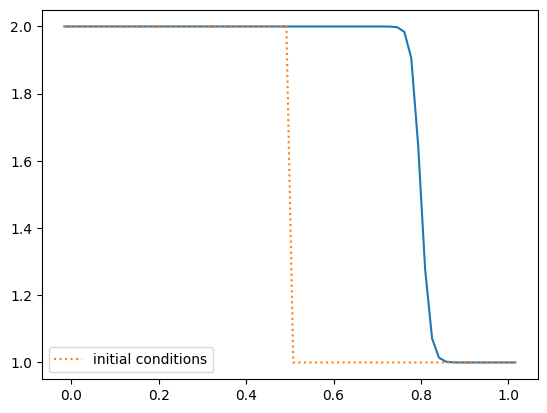

In [6]:
fig, ax = plt.subplots()
ax.plot(g.x, g.u)
ax.plot(g.x, g.uinit, ls=":", label="initial conditions")
ax.legend()

Let's write a simple function to compute the shock speed by simply finding the first zone
where the velocity drops below 1.5 and differencing that location at the different times.

```{note}
We should really interpolate to find the $x$ where the profile $u$ takes some particular value
in the shock profile to get a more accurate measure.
```

In [7]:
def shock_speed(g, tmax):
    x0 = g.x[g.uinit <= 1.5][0]
    x1 = g.x[g.u <= 1.5][0]
    return (x1 - x0) / tmax

Now let's see how the shock speed behaves with resolution

In [8]:
for nx in [64, 128, 256, 512]:
    g = burgers_solve(nx, C, tmax, init_cond=shock)
    speed = shock_speed(g, tmax)
    print(f"nx: {nx:4}, shock speed = {speed:7.3f}")

nx:   64, shock speed =   1.508
nx:  128, shock speed =   1.496
nx:  256, shock speed =   1.490
nx:  512, shock speed =   1.497


## Non-conservative update

In [9]:
nx = 64
tmax = 0.2
C = 0.8

g = burgers_solve(nx, C, tmax, init_cond=shock, method="non-conservative")

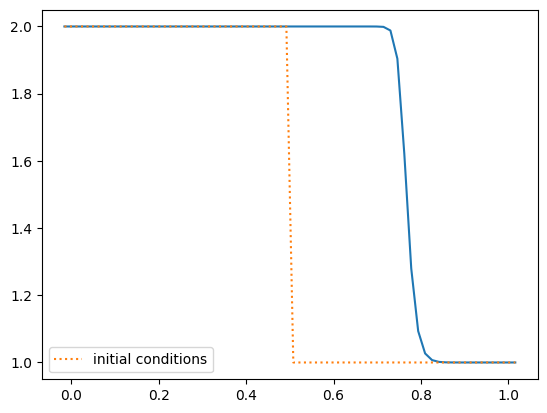

In [10]:
fig, ax = plt.subplots()
ax.plot(g.x, g.u)
ax.plot(g.x, g.uinit, ls=":", label="initial conditions")
ax.legend()

In [11]:
for nx in [64, 128, 256, 512]:
    g = burgers_solve(nx, C, tmax, init_cond=shock, method="non-conservative")
    speed = shock_speed(g, tmax)
    print(f"nx: {nx:4}, shock speed = {speed:7.3f}")

nx:   64, shock speed =   1.349
nx:  128, shock speed =   1.339
nx:  256, shock speed =   1.373
nx:  512, shock speed =   1.370


These speeds are really different.

## Summary

We know the correct shock speed for this&mdash;our initial conditions are just a Riemann problem
and we derived the shock speed for that via the Rankine-Hugoniot jump conditions:

$$S = \frac{1}{2} (u_l + u_r)$$

so for our problem the shock speed is $S = 1.5$.

We see that the conservatively differenced method gets the correct shock speed but the non-conservative method does not.  The reason for this is that the shock represents a discontinuity where the derivative
$\partial u / \partial x$ is not defined.  The conservative formulation matches the finite-volume method,
where we use the flux difference to compute the update.  This casts the equation in integral rather
than differential form, where the discontinuity is not a problem.